## The SEAIRQ model

In the present notebook, we consider the stochastic version of the SEAIRQ model.

In the SEAIRQ model we consider, there are the following classes:

* **$S$** Susceptible
* **$E$** Exposed
* **$A$** Asymptomatic infected (this class is between $E$ and $I_a$, $I_s$, and models the time an individual is already infectious, but it is not clear yet whether the individual will remain asymptomatic)
* **$I_a$** Asymptomatic infected
* **$I_s$** Symptomatic infected
* **$R$** Recovered
* **$Q$** Quarantined

In the SEAIR model, once an individual is exposed, it undergoes the transitions

\begin{equation}
    E \rightarrow A \rightarrow I_x \rightarrow R,
\end{equation}

where $I_x$ is either $I_a$ or $I_s$.

In the SEAIRQ model, there is a finite rate from the states $S$, $E$, $A$, $I_a$, $I_s$ to a quarantined class $Q$, in which an individual does not contribute to any infection rates anymore.

# Outline of this notebook

In this notebook we 

1. Run and visualise a single simulation of the stochastic SEAIR model, obtained from the SEAIRQ model by setting all rates to the quarantine state $Q$ to zero.
2. Compare the result of 1. to a SEAIRQ model, in which only symptomatic infectives can get quarantined.
3. Compare the results of 1. and 2. to a SEAIRQ model, in which one could get quarantined in the states $E$, $A$, $I_a$, $I_s$.

For all cases, we also run 200 simulations to estimate the relevance of the stochastic nature of the dynamics.

# 0. Definition of the model

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

In [3]:
M = 1                  # the SIR model has no age structure
Ni = 10000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

# 
alpha = 0              # fraction of asymptomatic infectives 
beta  = 0.2            # infection rate 

gE    = 1.             # progression rate from E to A
gA   = 0.2            # rate to go from A to Ia
gIa   = 0.1            # removal rate of asymptomatic infectives 
gIs   = 0.1            # removal rate of symptomatic infectives 
gE    = 0.04           # removal rate of E
fsa   = 1              # Fraction by which symptomatic individuals do not self isolate

E0  = np.array([0])
A0  = np.array([1])
Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([20])     # we take these to be symptomatic 
Q0  = np.array([0])
R0  = np.array([0])     # and assume there are no removed individuals initially 
S0  = N-(Ia0+Is0+R0+E0)    # The initial susceptibles are obtained from S + E + A + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and number of datapoints
Tf = 500;  Nt=Tf+1;  

# 1. SEAIR model

In [4]:
# For the SEAIR model, we set all rates to the Q-class to zero
tS    = 0.0            # rate S  -> Q
tE    = 0.00           # rate E  -> Q
tA    = 0.00           # rate A  -> Q
tIa   = 0.00           # rate Ia -> Q
tIs   = 0.00           # rate Is -> Q
#tIs   = 0.05           # rate Is -> Q

# instantiate model
parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa,
             'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs}
model = pyross.stochastic.SEAIRQ(parameters, M, Ni)

# simulate model
data=model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nt)

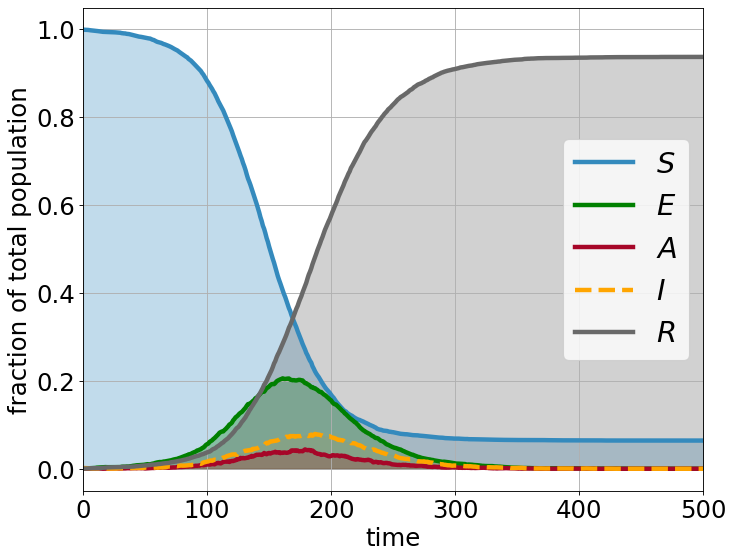

In [5]:
# plot the results of the simulation

S  = data['X'][:,0].flatten()
E  = data['X'][:,1].flatten()
A  = data['X'][:,2].flatten()
Ia = data['X'][:,3].flatten()
Is = data['X'][:,4].flatten()
Q  = data['X'][:,5].flatten()
t = data['t']


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, A/N, color='#A60628', alpha=0.3)
plt.plot(t, A/N, '-', color='#A60628', label='$A$', lw=4)

plt.fill_between(t, 0, (Ia+Is)/N, color='orange', alpha=0.1)
plt.plot(t, (Ia+Is)/N, '-', color='orange', label='$I$', ls='--',lw=4)

R=N-S-E-A-Ia-Is; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.xlabel(r'time')
plt.ylabel(r'fraction of total population')
plt.autoscale(enable=True, axis='x', tight=True)

### Averaging over several simulations

We now run 200 simulations, and consider the total number of susceptibles at the end of the simulation

In [6]:
# run 200 simulations, calculate mean and standard deviation

# This might take a while.
N_runs = 200
trajectories_SEAIR = np.zeros([N_runs,Nt,6],dtype=float)
for i in range(N_runs):
    print('Running simulation {0} of {1}'.format(i+1,N_runs),end='\r')
    cur_result = model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nt)
    trajectories_SEAIR[i] = cur_result['X']
t_SEAIR = cur_result['t']

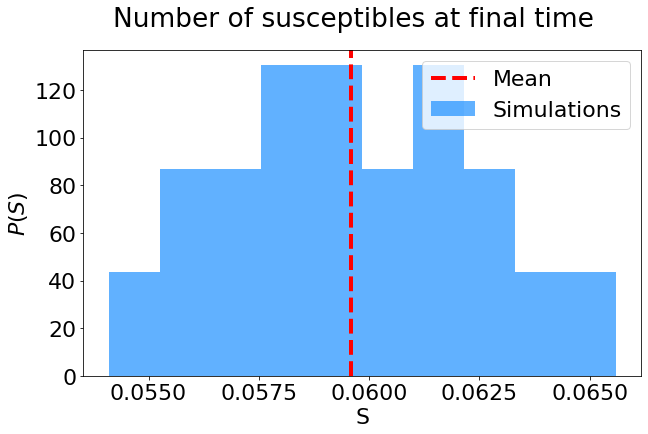

At final time, on average 6.0% of the population has never been infected.


In [7]:
S_final_SEAIR = trajectories_SEAIR[:,-1,0]/N

mean_S_final_SEAIR = np.mean( S_final_SEAIR )
std_S_final_SEAIR = np.std( S_final_SEAIR )

hist, bin_edges = np.histogram(S_final_SEAIR, bins= 10,density=True)
bin_centers = bin_edges[1:] + bin_edges[:-1]
bin_centers /= 2

fig,ax = plt.subplots(1,1,figsize=(10,6))
fig.suptitle('Number of susceptibles at final time')
ax.bar(bin_centers,hist,width=bin_centers[1]-bin_centers[0],
       color='dodgerblue',label='Simulations',
      alpha=0.7)
ax.axvline(mean_S_final_SEAIR,ls='--',lw=4,color='red',
         label= 'Mean')
ax.locator_params(axis='x', nbins=6)
ax.legend() #loc=8)
ax.set_xlabel(r'S')
ax.set_ylabel(r'$P(S)$')
plt.show()
#fig.savefig('S_distribution_SEAIR.png',bbox_inches='tight',dpi=100)
plt.close()

print('At final time, on average {0:3.1f}% of the population has never been infected.'.format(mean_S_final_SEAIR*100))

# 2. SEAIRQ model

We now set the rate at which symptomatic infectives get quarantined to $1/20$ days. All other classes stay as before, i.e. never get quarantined.

(Technically, this is similar to changing the self-isolation parameter "fsa".)

In [8]:
# We now consider a nonzero rate Is -> Q
tS    = 0.0            # rate S  -> Q
tE    = 0.00           # rate E  -> Q
tA    = 0.00           # rate A  -> Q
tIa   = 0.00           # rate Ia -> Q
tIs   = 0.05           # rate Is -> Q

# instantiate model
parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa,
             'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs}
model = pyross.stochastic.SEAIRQ(parameters, M, Ni)

# simulate model
data=model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nt)

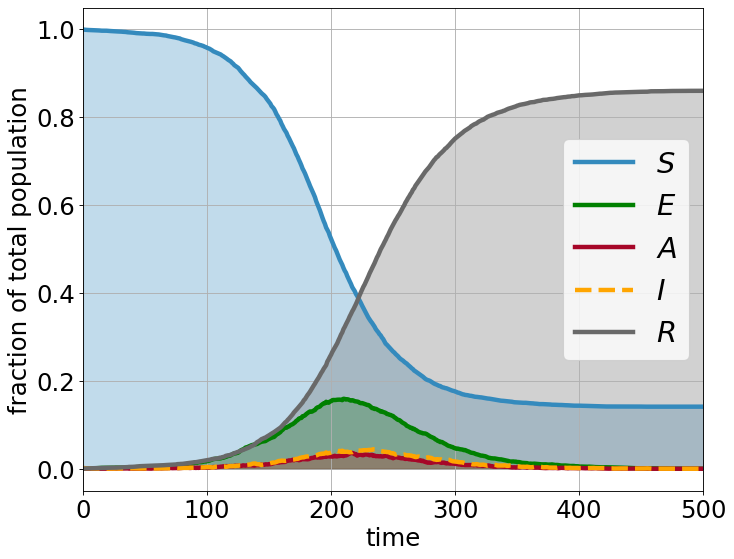

In [9]:
# plot the results of the simulation

S  = data['X'][:,0].flatten()
E  = data['X'][:,1].flatten()
A  = data['X'][:,2].flatten()
Ia = data['X'][:,3].flatten()
Is = data['X'][:,4].flatten()
Q  = data['X'][:,5].flatten()
t = data['t']


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, A/N, color='#A60628', alpha=0.3)
plt.plot(t, A/N, '-', color='#A60628', label='$A$', lw=4)

plt.fill_between(t, 0, (Ia+Is)/N, color='orange', alpha=0.1)
plt.plot(t, (Ia+Is)/N, '-', color='orange', label='$I$', ls='--',lw=4)

R=N-S-E-A-Ia-Is; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.xlabel(r'time')
plt.ylabel(r'fraction of total population')
plt.autoscale(enable=True, axis='x', tight=True)

In [10]:
# run 200 simulations, calculate mean and standard deviation

# This might take a while
N_runs = 200
trajectories_SEAIRQ1 = np.zeros([N_runs,Nt,6],dtype=float)
for i in range(N_runs):
    print('Running simulation {0} of {1}'.format(i+1,N_runs),end='\r')
    cur_result = model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nt)
    trajectories_SEAIRQ1[i] = cur_result['X']
t_SEAIRQ1 = cur_result['t']

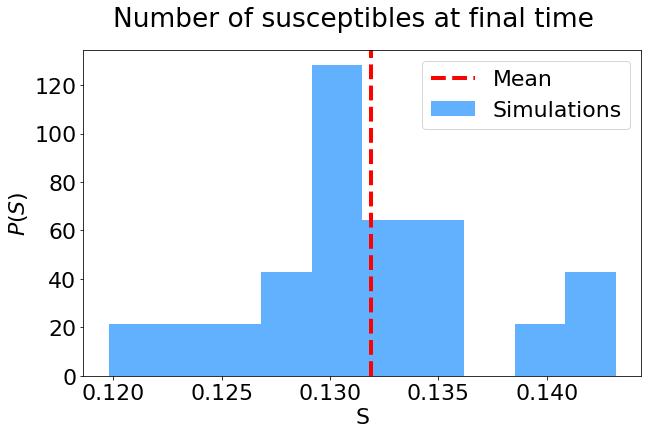

At final time, on average 13.2% of the population has never been infected.


In [11]:
S_final_SEAIRQ1 = trajectories_SEAIRQ1[:,-1,0]/N

mean_S_final_SEAIRQ1 = np.mean( S_final_SEAIRQ1 )
std_S_final_SEAIRQ1 = np.std( S_final_SEAIRQ1 )

hist, bin_edges = np.histogram(S_final_SEAIRQ1, bins= 10,density=True)
bin_centers = bin_edges[1:] + bin_edges[:-1]
bin_centers /= 2

fig,ax = plt.subplots(1,1,figsize=(10,6))
fig.suptitle('Number of susceptibles at final time')
ax.bar(bin_centers,hist,width=bin_centers[1]-bin_centers[0],
       color='dodgerblue',label='Simulations',
      alpha=0.7)
ax.axvline(mean_S_final_SEAIRQ1,ls='--',lw=4,color='red',
         label= 'Mean')
ax.locator_params(axis='x', nbins=6)
ax.legend() #loc=8)
ax.set_xlabel(r'S')
ax.set_ylabel(r'$P(S)$')
plt.show()
#fig.savefig('S_distribution_SEAIRQ1.png',bbox_inches='tight',dpi=100)
plt.close()

print('At final time, on average {0:3.1f}% of the population has never been infected.'.format(mean_S_final_SEAIRQ1*100))

By comparing this to the result from 1, we see that if symptomatic infectives are quarantined with a rate $1/20$ days, then the fraction of the population that never gets exposed increases by about 12%.

# 3. SEAIRQ model with more nonzero rates to quarantine class

We now set the rate at which symptomatic infectives get quarantined to $1/20$ days, and the rates at which the $E$, $A$, $I_a$, $I_s$ get quarantined to $1/50$ days.

In [12]:
# For the SEAIR model, we set all rates to the Q-state to zero
tS    = 0.0            # rate S  -> Q
tE    = 0.02           # rate E  -> Q
tA    = 0.02           # rate A  -> Q
tIa   = 0.02           # rate Ia -> Q
tIs   = 0.05           # rate Is -> Q

# instantiate model
parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa,
             'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs}
model = pyross.stochastic.SEAIRQ(parameters, M, Ni)

# simulate model
data=model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nt)

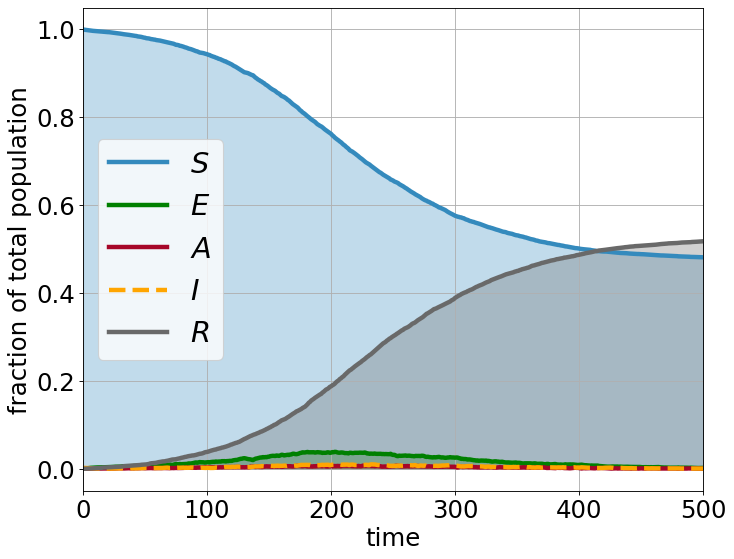

In [13]:
# plot the results of the simulation

S  = data['X'][:,0].flatten()
E  = data['X'][:,1].flatten()
A  = data['X'][:,2].flatten()
Ia = data['X'][:,3].flatten()
Is = data['X'][:,4].flatten()
Q  = data['X'][:,5].flatten()
t = data['t']


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, A/N, color='#A60628', alpha=0.3)
plt.plot(t, A/N, '-', color='#A60628', label='$A$', lw=4)

plt.fill_between(t, 0, (Ia+Is)/N, color='orange', alpha=0.1)
plt.plot(t, (Ia+Is)/N, '-', color='orange', label='$I$', ls='--',lw=4)

R=N-S-E-A-Ia-Is; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.xlabel(r'time')
plt.ylabel(r'fraction of total population')
plt.autoscale(enable=True, axis='x', tight=True)

We now observe qualitatively different behaviour as compared to 1 and 2. There is no clear peak in the number of exposed anymore, and the number of susceptibles decreases slowly. The processes has not reached a steady state yet, even after 500 days.

We now replot only the $E$, $A$, and $I = I_a + I_s$ classes, which are hardly visible in the above plot:

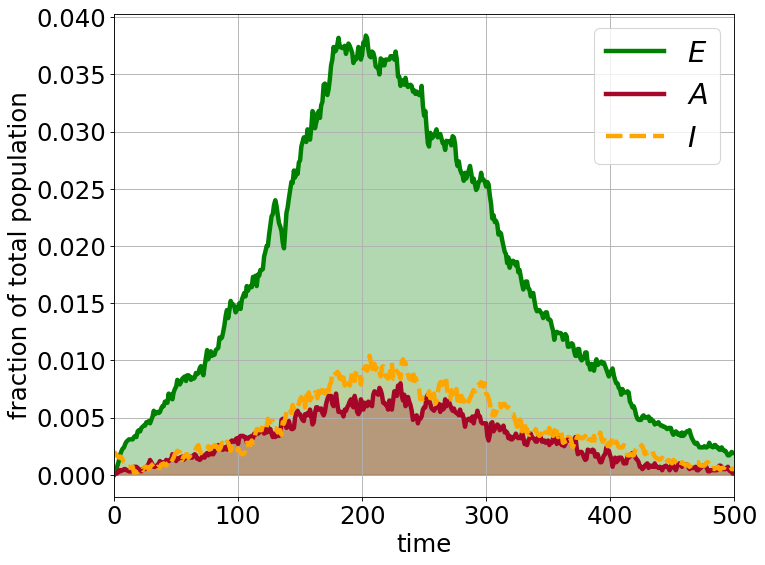

In [14]:
# plot only the E, A, and I = Ia + Is classes

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


#plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
#plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, A/N, color='#A60628', alpha=0.3)
plt.plot(t, A/N, '-', color='#A60628', label='$A$', lw=4)

plt.fill_between(t, 0, (Ia+Is)/N, color='orange', alpha=0.1)
plt.plot(t, (Ia+Is)/N, '-', color='orange', label='$I$', ls='--',lw=4)

#R=N-S-E-A-Ia-Is; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
#plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.xlabel(r'time')
plt.ylabel(r'fraction of total population')
plt.autoscale(enable=True, axis='x', tight=True)

As can be seen, the population fraction in these classes stays very low.

We now consider 200 simulations, and look at mean and standard deviation of the classes $E$, $A$, $I_a$, $I_s$:

In [15]:
# run 200 simulations, calculate mean and standard deviation

N_runs = 200
trajectories_SEAIRQ2 = np.zeros([N_runs,Nt,6],dtype=float)
for i in range(N_runs):
    print('Running simulation {0} of {1}'.format(i+1,N_runs),end='\r')
    cur_result = model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nt)
    trajectories_SEAIRQ2[i] = cur_result['X']
t_SEAIRQ2 = cur_result['t']

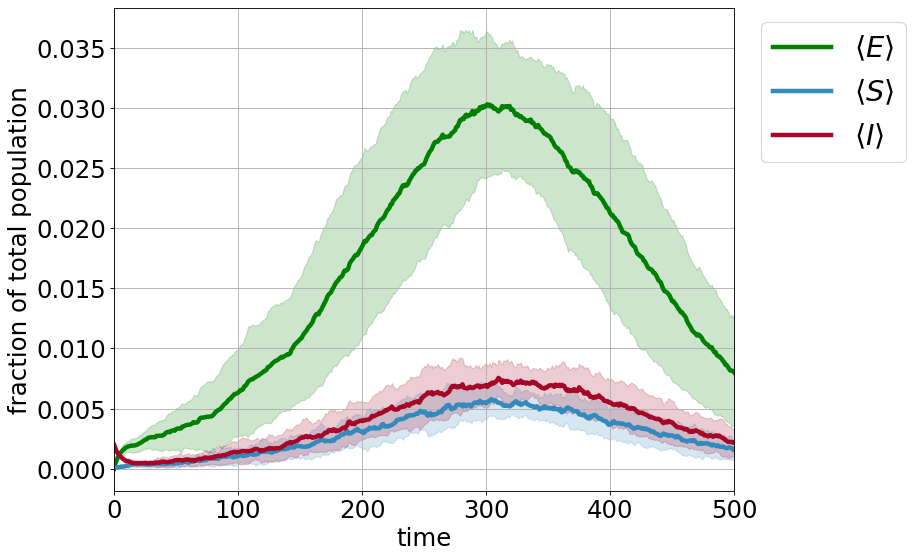

In [16]:
# plot means and standard deviations

mean_SEAIRQ2 = np.mean(trajectories_SEAIRQ2,axis=0)
std_SEAIRQ2 = np.std(trajectories_SEAIRQ2,axis=0)

E_SEAIRQ2 = mean_SEAIRQ2[:,1].flatten()
A_SEAIRQ2 = mean_SEAIRQ2[:,2].flatten()
# I = I_asymptomatic + I_symptomatic
I_SEAIRQ2 = np.mean(trajectories_SEAIRQ2[:,:,3] + trajectories_SEAIRQ2[:,:,4] ,axis=0).flatten()

dE_SEAIRQ2 = std_SEAIRQ2[:,1].flatten()
dA_SEAIRQ2 = std_SEAIRQ2[:,2].flatten()
dI_SEAIRQ2 =  np.std(trajectories_SEAIRQ2[:,:,3] + trajectories_SEAIRQ2[:,:,4],axis=0).flatten()


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t_SEAIRQ2,(E_SEAIRQ2 - dE_SEAIRQ2)/N,(E_SEAIRQ2 + dE_SEAIRQ2)/N,color="green", alpha=0.2)
plt.plot(t_SEAIRQ2, E_SEAIRQ2/N, '-', color="green", label=r'$\langle E\rangle$', lw=4)

plt.fill_between(t_SEAIRQ2,(A_SEAIRQ2 - dA_SEAIRQ2)/N,(A_SEAIRQ2 + dA_SEAIRQ2)/N,color="#348ABD", alpha=0.2)
plt.plot(t_SEAIRQ2, A_SEAIRQ2/N, '-', color="#348ABD", label=r'$\langle S\rangle$', lw=4)

plt.fill_between(t_SEAIRQ2,(I_SEAIRQ2 - dI_SEAIRQ2)/N,(I_SEAIRQ2 + dI_SEAIRQ2)/N,color="#A60628", alpha=0.2)
plt.plot(t_SEAIRQ2, I_SEAIRQ2/N, '-', color="#A60628", label=r'$\langle I\rangle$', lw=4)

plt.legend(fontsize=26,loc='upper right',bbox_to_anchor=(1.3,1)); plt.grid() 
plt.xlabel(r'time')
plt.ylabel(r'fraction of total population')
plt.autoscale(enable=True, axis='x', tight=True)

While the solid lines denote the instantaneous means, the colored shaded regions denote the standard deviation of the samples from the instantaneous mean.

As can be seen, the peak now is at about 350 days, and after 500 days the average numbers in all classes are decreasing.